## Auto Encoder by using Multi-layered Perceptron (MLP)

Auto Encoder for handwritten numbers (MNIST) by MLP

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# load MNIST data
train_Dataset = dsets.MNIST(
      root='./data',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

test_dataset = dsets.MNIST(
      root='./data',  
      train=False, 
      transform=transforms.ToTensor(),
      download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_Dataset,   # 分割するデータセット
      [48000, 12000])  # 分割数
 
print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))  
print('test_dataset = ', len(test_dataset))


train_dataset =  48000
valid_dataset =  12000
test_dataset =  10000


In [3]:
# set data loader
minibatch_size = 64
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=minibatch_size,  # ミニバッチの指定
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数

valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=minibatch_size, 
      shuffle=False,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=minibatch_size, 
      shuffle=False,
      num_workers=2)


In [4]:
# Multi Layer Perceptron Network
n_hidden = 256
class AENet (nn.Module):
    def __init__(self):
        super(AENet, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, n_hidden)
        self.bn1 = nn.BatchNorm1d(num_features=n_hidden, affine=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(n_hidden, 28 * 28 * 1)
        
    def forward(self, x):
        y = self.fc1(x)
        y = self.bn1(y)
#        y = self.dropout1(y)
        y = y + 0.1*torch.randn(n_hidden).cuda()
        z = self.fc2(y)
        return z

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AENet().to(device)
print(device)

# optimizing
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001)
#optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


cuda


training start ...
Learning Rate =  0.01
Epoch [1/1000] train Loss: 0.00108929 | val_loss: 0.00109081
Learning Rate =  0.01
Epoch [2/1000] train Loss: 0.00066808 | val_loss: 0.00067115
Learning Rate =  0.01
Epoch [3/1000] train Loss: 0.00050363 | val_loss: 0.00050511
Learning Rate =  0.01
Epoch [4/1000] train Loss: 0.00044428 | val_loss: 0.00044604
Learning Rate =  0.01
Epoch [5/1000] train Loss: 0.00040988 | val_loss: 0.00041073
Learning Rate =  0.01
Epoch [6/1000] train Loss: 0.00038424 | val_loss: 0.00038603
Learning Rate =  0.01
Epoch [7/1000] train Loss: 0.00036037 | val_loss: 0.00036216
Learning Rate =  0.01
Epoch [8/1000] train Loss: 0.00034236 | val_loss: 0.00034340
Learning Rate =  0.01
Epoch [9/1000] train Loss: 0.00032750 | val_loss: 0.00032944
Learning Rate =  0.01
Epoch [10/1000] train Loss: 0.00031325 | val_loss: 0.00031498
Learning Rate =  0.01
Epoch [11/1000] train Loss: 0.00030080 | val_loss: 0.00030255
Learning Rate =  0.01
Epoch [12/1000] train Loss: 0.00028969 | val

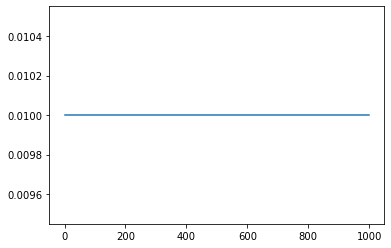

In [5]:
###  training
print ('training start ...')
num_epochs = 1000   

lrs = []

# initialize list for plot graph after training
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, val_loss = 0, 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, images)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization

    # ======== update learning rate ======
    lrs.append(optimizer.param_groups[0]["lr"])
    print("Learning Rate = ",optimizer.param_groups[0]["lr"])
#    scheduler.step()

    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:        
          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, images)
          train_loss += loss.item()
#          acc = (outputs.max(1)[1] == labels).sum()
#          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
#    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          outputs = net(images)
#          print(outputs.shape)
          loss = criterion(outputs, images)
          val_loss += loss.item()
#          acc = (outputs.max(1)[1] == labels).sum()
#          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
#    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.8f} | val_loss: {val_loss:.8f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)

plt.plot(range(num_epochs),lrs)

In [6]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_loss = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, images)
        test_loss += loss.item()
    print('test_loss: {loss:.8f}'.format(loss=test_loss / len(test_loader.dataset))) 

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_loss: 0.00003203


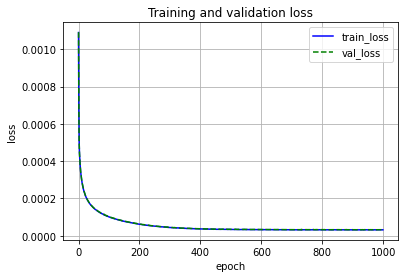

In [7]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
#plt.ylim([0.0,0.0001])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('AE_mnist_loss.png')
plt.show()


torch.Size([16, 784])
torch.Size([16, 784])
0
Original Image


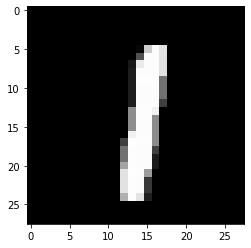

Estimated Image


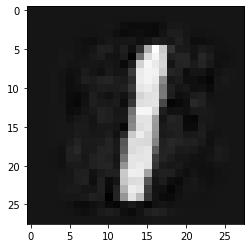

1
Original Image


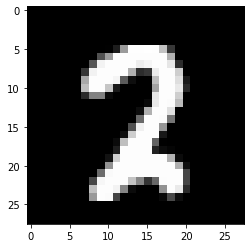

Estimated Image


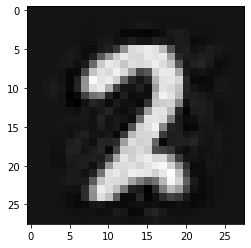

2
Original Image


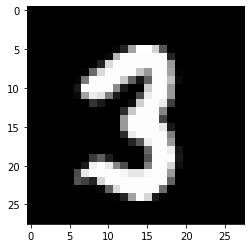

Estimated Image


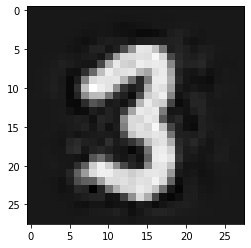

3
Original Image


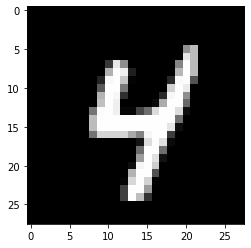

Estimated Image


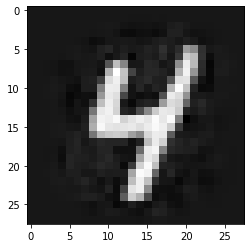

4
Original Image


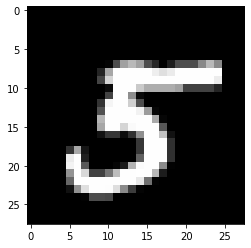

Estimated Image


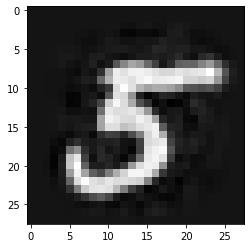

5
Original Image


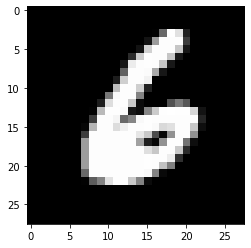

Estimated Image


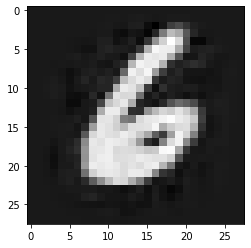

6
Original Image


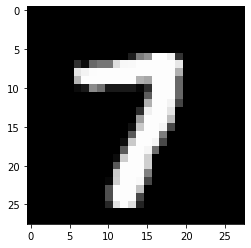

Estimated Image


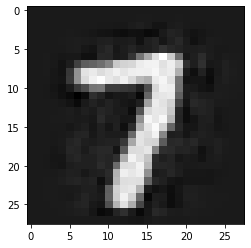

7
Original Image


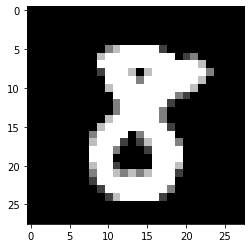

Estimated Image


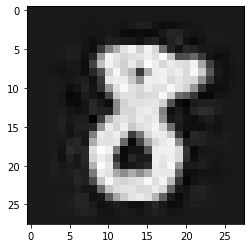

8
Original Image


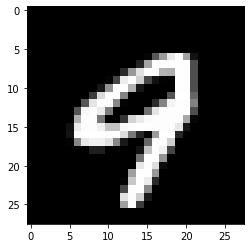

Estimated Image


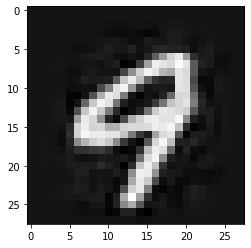

9
Original Image


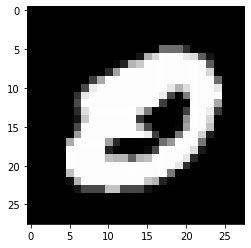

Estimated Image


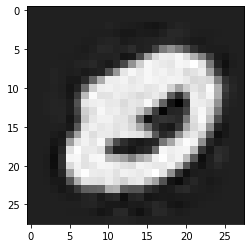

In [8]:
net.eval()
with torch.no_grad():
    images, labels in test_loader
    images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
    outputs = net(images)
    images=images.to('cpu')
    outputs=outputs.to('cpu')
    print(images.shape)
    print(outputs.shape)

for i in range(10):
    print(i)
    orgimg = images[i,:].numpy().reshape([28,28])
#    print(orgimg.shape)
    print('Original Image')
    plt.imshow(orgimg, cmap = "gray")
    ofname = "./images/orgimg-{:1d}".format((i+1)%10)
    plt.savefig(ofname)
    plt.show()
    estimg = outputs[i,:].numpy().reshape([28,28])
#    print(orgimg.shape)
    print('Estimated Image')
    plt.imshow(estimg, cmap = "gray")
    pfname = "./images/predimg-{:1d}".format((i+1)%10)
    plt.savefig(pfname)
    plt.show()
    